In [1]:
# Numerical/scientific computing packages.
import numpy as np
import scipy
import copy
import pandas as pd
import seaborn as sns
import csv

# Machine learning package.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error

# Useful for saving our models.
import pickle

# Plotting packages.
import matplotlib
import matplotlib.pyplot as plt

print('Finished successfully loading packages')

Finished successfully loading packages


In [2]:
import random
random.seed(18618637)

lda_df = pd.read_csv('reducedDataSets/lda_training.csv')
lda_df = lda_df.drop("Unnamed: 0", axis=1)
lda_df = lda_df.reset_index()
lda_df = lda_df.drop("index", axis=1)
lda_df.head()

,0,1,2,genre_label
0,-0.226500,0.561496,0.878766,4
1,0.619170,-1.666899,-0.573924,1
2,5.178228,2.360251,-1.212532,1
3,-0.368417,-0.404548,1.697220,0
4,-1.521510,-0.215592,-0.220435,6


In [3]:
X_train = lda_df.drop("genre_label", axis=1)
y_train = lda_df["genre_label"]

In [4]:
X_test = pd.read_csv('reducedDataSets/lda_x_testing.csv')
X_test = X_test.drop("Unnamed: 0", axis=1)
X_test = X_test.reset_index()
X_test = X_test.drop("index", axis=1)
print("Shape: ", X_test.shape)
X_test.head()

Shape:  (9233, 3)


,0,1,2
0,-3.608121,1.397075,-1.676036
1,-1.184365,-0.267707,0.754754
2,1.539927,0.862079,0.600338
3,-1.616452,0.247386,-0.588675
4,-0.772778,0.412188,-1.510453


In [5]:
y_test = pd.read_csv('reducedDataSets/lda_y_testing.csv')
y_test = y_test.drop("Unnamed: 0", axis=1)
y_test = y_test.reset_index()
y_test = y_test.drop("index", axis=1)
print("Shape: ", y_test.shape)
y_test.head()

Shape:  (9233, 1)


,genre_label
0,8
1,0
2,4
3,6
4,5


In [6]:
label_genre_mapping = {
    0: 'Alternative', 
    1: 'Anime', 
    2: 'Blues', 
    3: 'Classical', 
    4: 'Country', 
    5: 'Electronic', 
    6: 'Hip-Hop', 
    7: 'Jazz', 
    8: 'Rap', 
    9: 'Rock'
}

### Let's start by building perceptron

Classification Report:

               precision    recall  f1-score   support

           0       0.06      0.03      0.04       988
           1       0.22      0.07      0.10      1000
           2       0.21      0.10      0.13       959
           3       0.52      0.89      0.66       987
           4       0.32      0.52      0.40       984
           5       0.40      0.66      0.49      1000
           6       0.00      0.00      0.00       645
           7       0.00      0.00      0.00       966
           8       0.41      0.87      0.56       940
           9       0.53      0.16      0.24       764

    accuracy                           0.34      9233
   macro avg       0.27      0.33      0.26      9233
weighted avg       0.27      0.34      0.27      9233



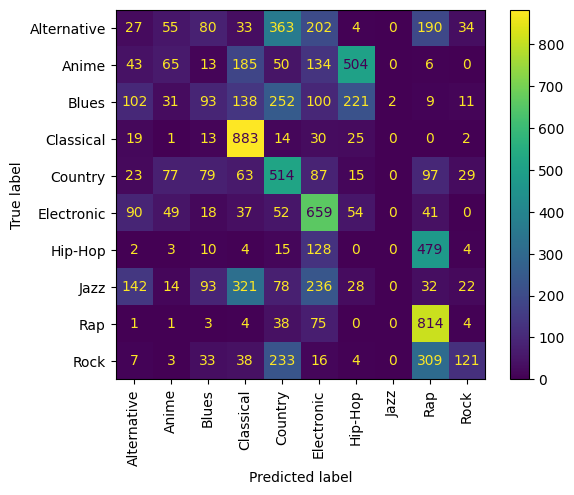

In [7]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

perceptron = Perceptron(tol=1e-3, random_state=18618637, shuffle=True)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)

report = classification_report(y_test, y_pred)  # Use numeric labels directly
print("Classification Report:\n\n", report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_genre_mapping.values()))
disp.plot(xticks_rotation=90)

### Let's now add a simple neural network

In [36]:
import torch
from torch import nn, optim

class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        out = self.softmax(out)
        return out

input_size = X_train.shape[1]  # number of predictors
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
num_classes = len(y_train.unique()) # number of classes

model = MusicGenreClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes)
print(model)

MusicGenreClassifier(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [37]:
import numpy as np

X_train_array = X_train.values.astype(np.float32)
y_train_array = y_train.values.astype(np.float32)
X_test_array = X_test.values.astype(np.float32)
y_test_array = y_test.values.astype(np.float32)

X_train_tensor = torch.as_tensor(X_train_array)
y_train_tensor = torch.as_tensor(y_train_array)
X_test_tensor = torch.as_tensor(X_test_array)
y_test_tensor = torch.as_tensor(y_test_array)

In [38]:
from sklearn.metrics import roc_auc_score

auc_scores = []
losses = []

def train_model(model, criterion, optimizer, inputs, labels, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss = loss.item()
        losses.append(epoch_loss)
        loss.backward()
        metrics = estimate_auc_rmse_scores(model, X_test_tensor, y_test_tensor)
        auc_scores.append(metrics)
        optimizer.step()
        if epoch % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.3f}; AUC score: {metrics:.3f}')

# pass testing tensors for these:
def estimate_auc_rmse_scores(model, input_tensor, true_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
    return roc_auc_score(true_labels.numpy(), outputs.numpy(), multi_class='ovr')

In [39]:
learning_rate = 0.001
lambda_l2 = 0.01
y_train_tensor = torch.as_tensor(y_train_array, dtype=torch.long)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, criterion=criterion, optimizer=optimizer, inputs=X_train_tensor, labels=y_train_tensor, num_epochs=500)

Epoch [1/500], Loss: 2.303; AUC score: 0.449
Epoch [51/500], Loss: 2.071; AUC score: 0.806
Epoch [101/500], Loss: 1.984; AUC score: 0.830
Epoch [151/500], Loss: 1.956; AUC score: 0.841
Epoch [201/500], Loss: 1.949; AUC score: 0.845
Epoch [251/500], Loss: 1.945; AUC score: 0.847
Epoch [301/500], Loss: 1.943; AUC score: 0.848
Epoch [351/500], Loss: 1.942; AUC score: 0.849
Epoch [401/500], Loss: 1.941; AUC score: 0.850
Epoch [451/500], Loss: 1.940; AUC score: 0.850


In [40]:
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

def plot_auc_scores(auc_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(auc_scores, label='AUC Score')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.title('AUC Score Improvement over Epochs')
    plt.legend()
    plt.show()

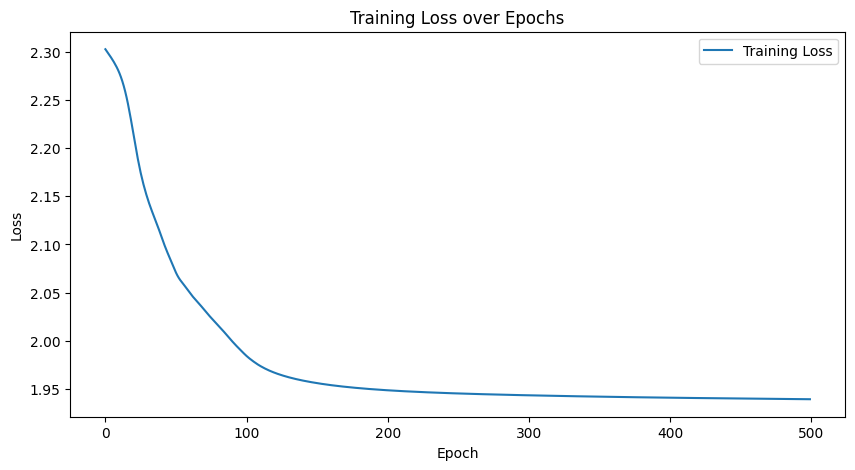

In [41]:
plot_losses(losses)

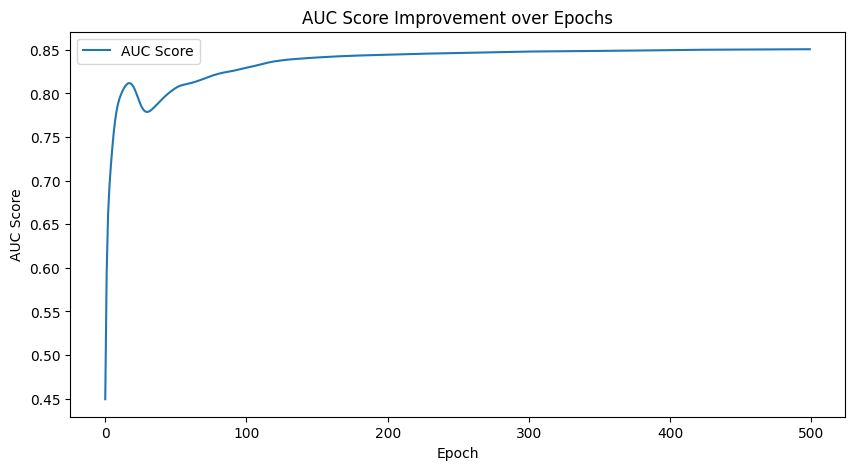

In [42]:
plot_auc_scores(auc_scores)

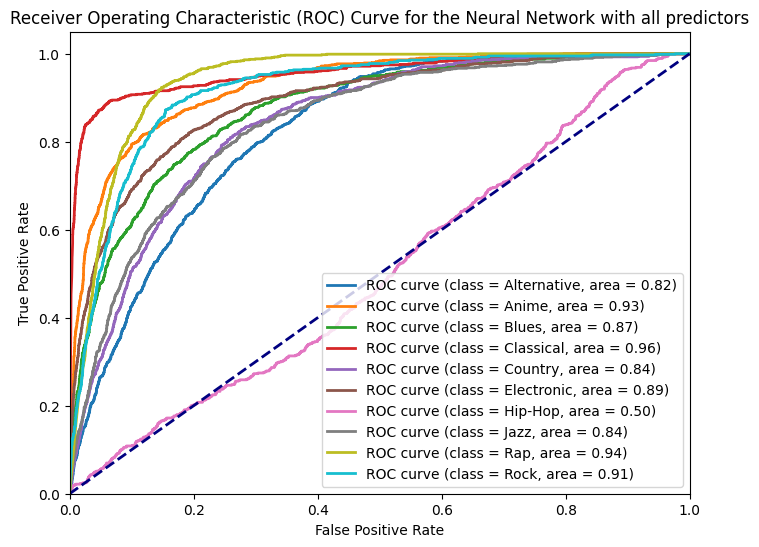

In [43]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

lb = LabelBinarizer()
lb.fit(y_test)
y_test_binary = lb.transform(y_test)

def graph_auc_curve_multiclass(model, input_tensor, true_labels, title="all predictors"):
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)

    probabilities = outputs.numpy()

    plt.figure(figsize=(8, 6))
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i], probabilities[:, i])
        auc_score_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (class = {0}, area = {1:0.2f})'.format(label_genre_mapping[lb.classes_[i]], auc_score_val))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for the Neural Network with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

graph_auc_curve_multiclass(model, X_test_tensor, y_test_tensor)

In [16]:
from sklearn.metrics import accuracy_score

def graph_auc_curve_multiclass(model, predicted_probabilities, true_labels, title="all predictors"):
    plt.figure(figsize=(8, 6))
    fpr = dict()
    tpr = dict()
    auc_score = dict()
    for i in range(len(lb.classes_)):
        fpr[i], tpr[i], _ = roc_curve(true_labels == lb.classes_[i], predicted_probabilities[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class = {0}, area = {1:0.2f})'.format(label_genre_mapping[lb.classes_[i]], auc_score[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for the model with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Now you can use DecisionTreeClassifier
clf = BaggingClassifier(DecisionTreeClassifier(criterion='gini'),
                        n_estimators=200, max_samples=1.0, bootstrap=True)
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
auc_score_val = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print("AUC:", auc_score_val)

Accuracy: 0.4694032275533413
AUC: 0.8762377106936542


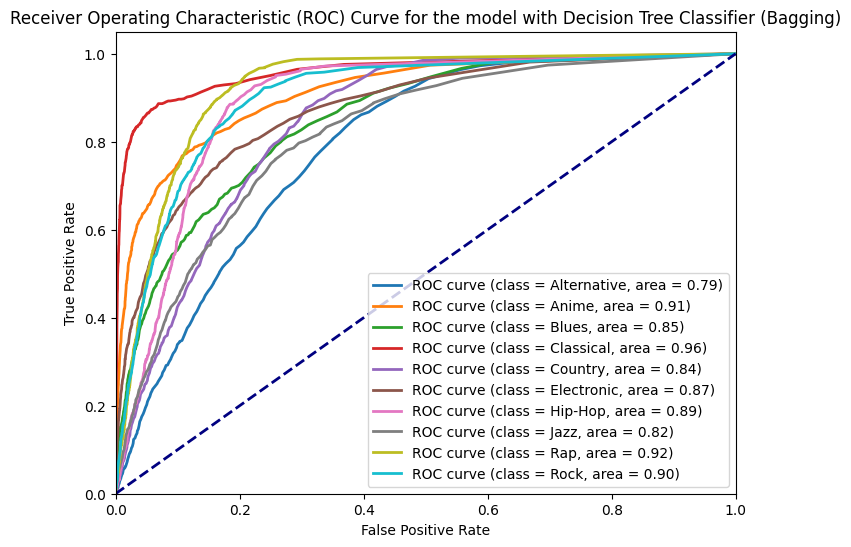

In [18]:
graph_auc_curve_multiclass(clf, clf.predict_proba(X_test), y_test, title="Decision Tree Classifier (Bagging)")

In [19]:
# Random forests
from sklearn.ensemble import RandomForestClassifier

# Now we try RandomForests on the same data. Again, RandomForests is just a method to ensemble your base models
# and will be used in the same way bagging was. The difference is in the number of features being selected to make a node split
clf = RandomForestClassifier(n_estimators=1000, max_samples=0.1, max_features=0.5,bootstrap=True, criterion='gini')
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
auc_score_val = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print("AUC:", auc_score_val)

Accuracy: 0.5151088486948987
AUC: 0.8984971043166095


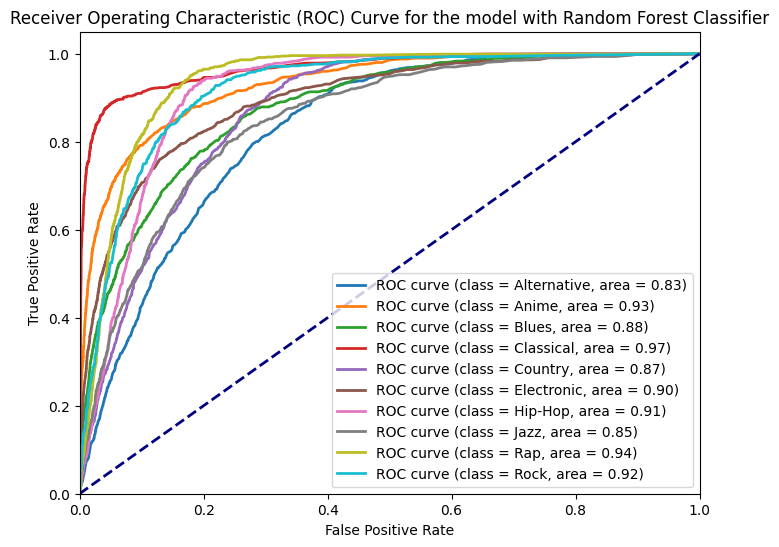

In [20]:
graph_auc_curve_multiclass(clf, clf.predict_proba(X_test), y_test, title="Random Forest Classifier")

In [21]:
# Next we implement gradient boosting, in particular the Adaboost algorithm.
# Remember, gradient boosting algorithms involve iteratively improving the decision trees
# and hence involve a learning rate similar to logistic regressions.
from sklearn.ensemble import AdaBoostClassifier
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=2000, learning_rate=0.01
)
bdt.fit(X_train, y_train)
preds = bdt.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
auc_score_val = roc_auc_score(y_test, bdt.predict_proba(X_test), multi_class='ovr')
print("AUC:", auc_score_val)

Accuracy: 0.37582584208816205
AUC: 0.8465815539557097


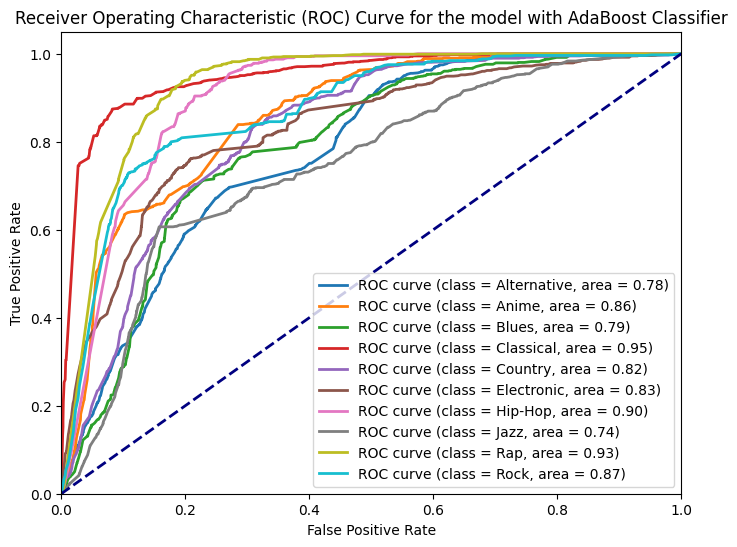

In [22]:
graph_auc_curve_multiclass(bdt, bdt.predict_proba(X_test), y_test, title="AdaBoost Classifier")

In [23]:
# Logistic Regression
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

model_lr = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=18618637)
model_lr.fit(X_train, y_train)
preds = model_lr.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
auc_score_val = roc_auc_score(y_test, model_lr.predict_proba(X_test), multi_class='ovr')
print("AUC:", auc_score_val)

Accuracy: 0.48175024369110797
AUC: 0.8772897594800396


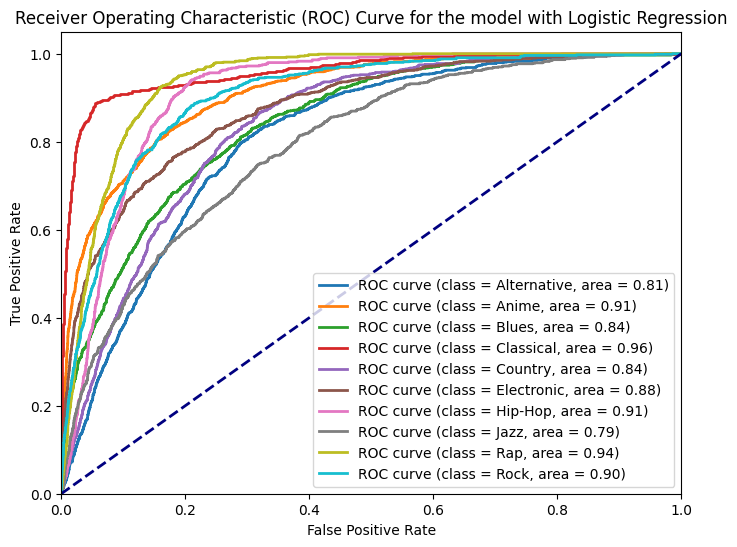

In [24]:
graph_auc_curve_multiclass(model_lr, model_lr.predict_proba(X_test), y_test, title="Logistic Regression")

In [25]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_test)
print("Test score: ", roc_auc_score(y_test, y_pred, multi_class='ovr'))

Test score:  0.6627094241847804


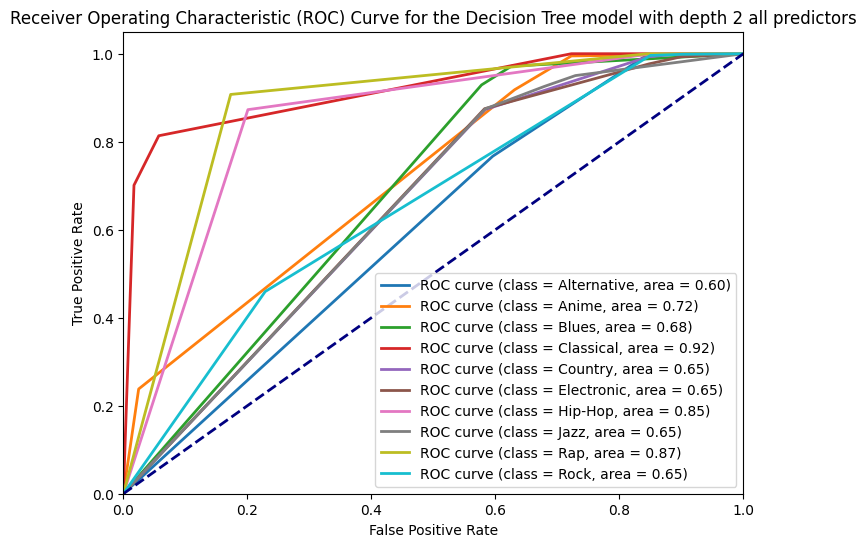

train: 0.7262220038237436


In [26]:
def graph_auc_curve_multiclass(model, predicted_probabilities, true_labels, title="all predictors"):
    plt.figure(figsize=(8, 6))
    # Calculate ROC curve for each class
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i], predicted_probabilities[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (class = {0}, area = {1:0.2f})'.format(label_genre_mapping[lb.classes_[i]], auc_score))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for the Decision Tree model with depth 2 {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
predicted_probabilities = dt.predict_proba(X_test)
graph_auc_curve_multiclass(dt, predicted_probabilities, y_test)

y_pred = dt.predict_proba(X_train)
auc_train = roc_auc_score(y_train, y_pred, multi_class='ovr')
print('train:', auc_train)